# Proyek Analisis Data: Bike Sharing Dataset
- **Nama:** Arbaz Ferdiansah
- **Email:** doozyarbaz@gmail.com
- **ID Dicoding:** arbaz_ferdiansah

## Menentukan Pertanyaan Bisnis

- Bagaimana mengidentifikasi pola penggunaan sepeda berdasarkan waktu (jam) dalam sehari menggunakan clustering untuk mengoptimalkan ketersediaan sepeda?
- Bagaimana pola penggunaan sepeda berbeda antara hari kerja dan akhir pekan menggunakan analisis RFM sederhana?

## Import Semua Packages/Library yang Digunakan

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data Wrangling

### Gathering Data

In [40]:
hour_df = pd.read_csv("data/hour.csv")

day_df = pd.read_csv("data/day.csv")

In [41]:
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [42]:
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Insight:**
- **hour.csv** = jumlah berbagi sepeda diagregasi per jam (17389 jam). Kolom: indeks rekaman, tanggal, musim, tahun, bulan, jam, liburan, hari dalam seminggu, hari kerja, cuaca, suhu, kelembaban, kecepatan angin, jumlah pengguna sepeda kasual, jumlah pengguna sepeda terdaftar, total sepeda sewaan.
- **day.csv** = jumlah berbagi sepeda yang dikumpulkan setiap hari (721 hari). Kolom: indeks rekaman, tanggal, musim, tahun, bulan, liburan, hari dalam seminggu, hari kerja, cuaca, suhu, kelembaban, kecepatan angin, jumlah pengguna sepeda kasual, jumlah pengguna sepeda terdaftar, total sepeda sewaan
- Kedua file mempunyai kolom yang sama, kecuali kolom 'hour'

### Assessing Data

In [43]:
#Menilai Data hour_df
hour_df.info()
print(f"Missing values: {hour_df.isna().sum()}")
print(f"Jumlah duplikasi: {hour_df.duplicated().sum()}")
hour_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
Missing values: instant       0
dteday        0
s

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [44]:
#Menilai Data day_df
day_df.info()
print(f"Missing values: {day_df.isna().sum()}")
print(f"Jumlah duplikasi: {day_df.duplicated().sum()}")
day_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
Missing values: instant       0
dteday        0
season        0
yr            0
mnth         

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


**Insight:**
- **hour.csv** = Tidak ada _missing values_ dan _duplicates_, tetapi tipe data pada kolom _dteday_ seharusnya _datetime_
- **day.csv** = Tidak ada _missing values_ dan _duplicates_, tetapi tipe data pada kolom _dteday_ seharusnya _datetime_

### Cleaning Data

In [45]:
# Mengubah tipe data kolom dteday menjadi datetime
day_df['dteday'] = pd.to_datetime(day_df['dteday']) 
# Memastikan perubahan berhasil
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [46]:
# Mengubah tipe data dteday menjadi datetime
hour_df['dteday'] = pd.to_datetime(hour_df['dteday']) 
# Memastikan perubahan berhasil
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

**Insight:**
- **hour.csv** = mengubah tipe data di kolom dteday dari _object_ menjadi _datetime_
- **day.csv** = mengubah tipe data di kolom dteday dari _object_ menjadi _datetime_

## Exploratory Data Analysis (EDA)

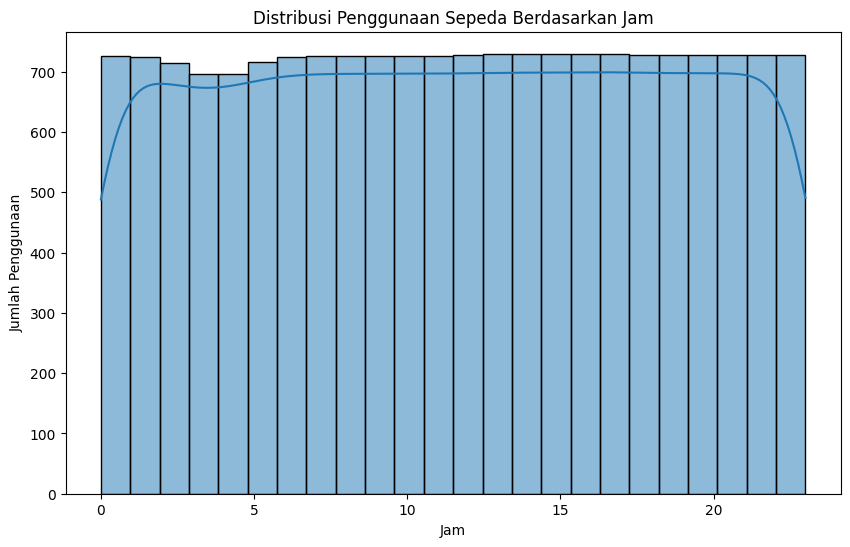

In [47]:
# Membuat histogram
plt.figure(figsize=(10, 6))
sns.histplot(hour_df['hr'], bins=24, kde=True)
plt.title('Distribusi Penggunaan Sepeda Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Penggunaan')
plt.show()

**Insight:**
- Pola penggunaan sepeda cukup konsisten sepanjang hari, tetapi sedikit menurun di sekitar jam 0 dan jam 23.
- Jumlah penggunaan sepeda per jam berkisar antara 500 sampai 700.

C:\Users\arbaz\AppData\Local\Temp\ipykernel_20524\2301146456.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=day_df, x='season', y='cnt', palette='Set3')


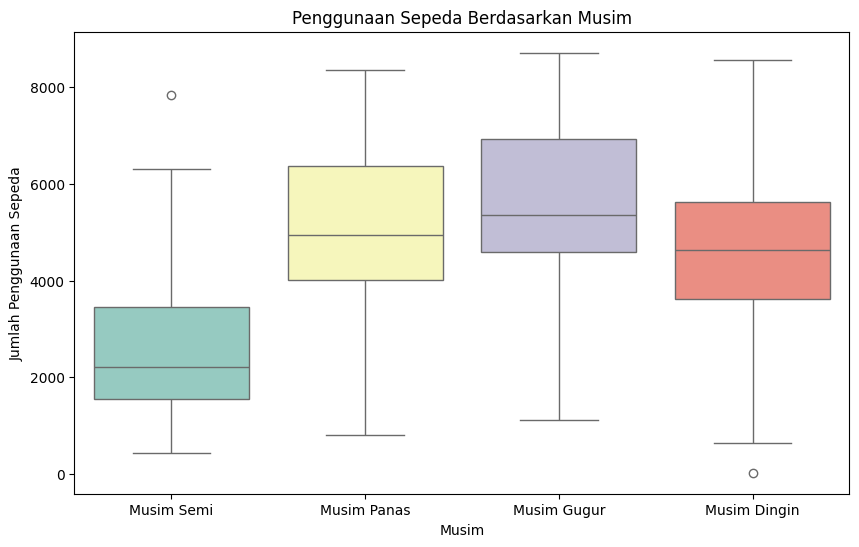

In [48]:
# Menggunakan replace untuk mengganti nilai season
# Menggunakan def untuk tidak menuliskan dua kali
def replace_season(df):
    df["season"] = df["season"].replace({
        1: "Musim Semi", 
        2: "Musim Panas", 
        3: "Musim Gugur", 
        4: "Musim Dingin"
    })
    return df

hour_df = replace_season(hour_df)
day_df = replace_season(day_df)

# Membuat box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=day_df, x='season', y='cnt', palette='Set3')
plt.title('Penggunaan Sepeda Berdasarkan Musim')
plt.xlabel('Musim')
plt.ylabel('Jumlah Penggunaan Sepeda')
plt.show()

**Insight:**
- Penggunaan sepeda lebih tinggi pada musim gugur dan panas, sedangkan lebih rendah pada musim dingin dan semi berdasarkan median dan IQR masing-masing musim.

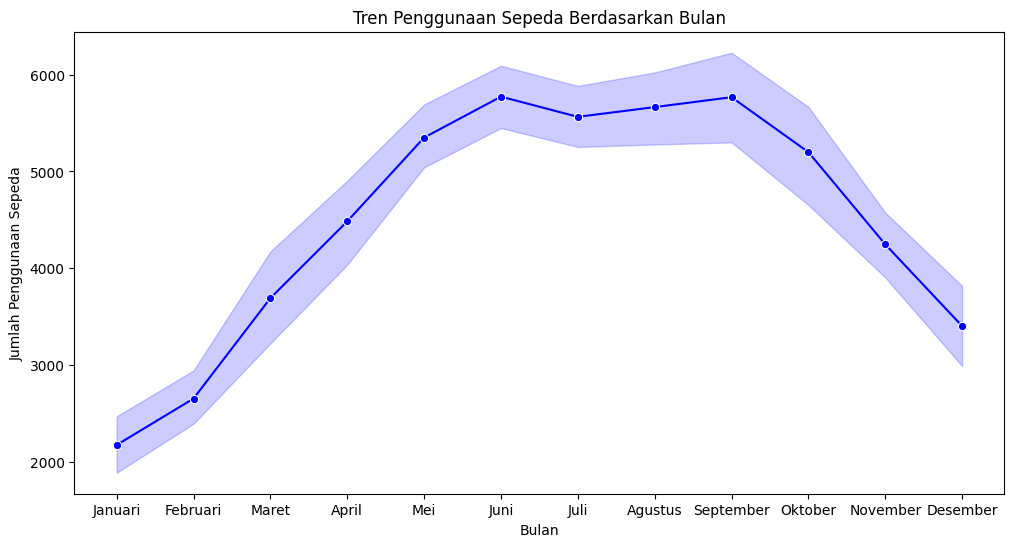

In [49]:
# Menggunakan replace untuk mengganti nilai season
# Menggunakan def untuk tidak menuliskan dua kali
def replace_month(df):
  df["mnth"] = df ["mnth"].replace({
    1: "Januari",
    2: "Februari",
    3: "Maret",
    4: "April",
    5: "Mei",
    6: "Juni",
    7: "Juli",
    8: "Agustus",
    9: "September",
    10: "Oktober",
    11: "November",
    12: "Desember"
  })
  return df

hour_df = replace_month(hour_df)
day_df = replace_month(day_df)

# Membuat line plot atau line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=day_df, x='mnth', y='cnt', marker='o', color='b')
plt.title('Tren Penggunaan Sepeda Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Penggunaan Sepeda')
plt.show()

**Insight:**
- Memberikan gambaran tentang pola penggunaan sepeda sepanjang tahun
- Penggunaan sepeda mencapai puncaknya di bulan-bulan musim panas dan menurun selama musim dingin

C:\Users\arbaz\AppData\Local\Temp\ipykernel_20524\3518664379.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=day_df, x='workingday', y='cnt', palette='pastel')


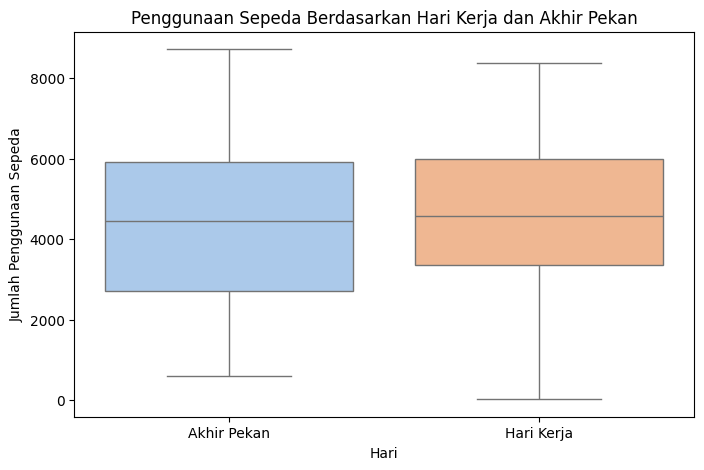

In [50]:
# Menggunakan replace untuk mengganti nilai season
# Menggunakan def untuk tidak menuliskan dua kali
def replace_workingday(df):
    df["workingday"] = df["workingday"].replace({
        0: "Akhir Pekan",
        1: "Hari Kerja"
    })
    return df

hour_df = replace_workingday(hour_df)
day_df = replace_workingday(day_df)

# Membuat box plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=day_df, x='workingday', y='cnt', palette='pastel')
plt.title('Penggunaan Sepeda Berdasarkan Hari Kerja dan Akhir Pekan')
plt.xlabel('Hari')
plt.ylabel('Jumlah Penggunaan Sepeda')
plt.show()

**Insight:**
- Penggunaan sepeda lebih tinggi pada hari kerja dibandingkan akhir pekan berdasarkan median dan IQR.

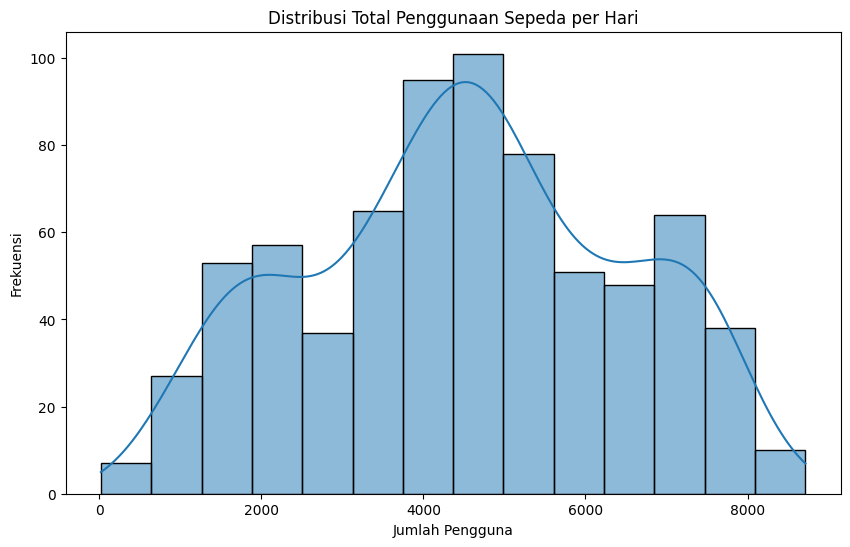

In [51]:
# Membuat histogram
plt.figure(figsize=(10, 6))
sns.histplot(day_df['cnt'], kde=True)
plt.title('Distribusi Total Penggunaan Sepeda per Hari')
plt.xlabel('Jumlah Pengguna')
plt.ylabel('Frekuensi')
plt.show()

**Insight:**
- Jumlah penggunaan sepeda per hari bervariasi dengan kebanyakan hari memiliki jumlah pengguna yang tinggi, tetapi berada di tengah kisaran.

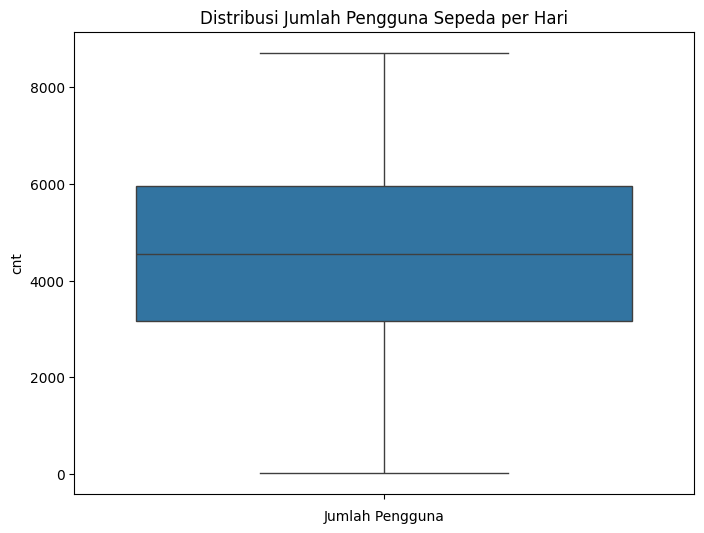

In [52]:
# Membuat box plot
plt.figure(figsize=(8, 6))
sns.boxplot(day_df['cnt'])
plt.title('Distribusi Jumlah Pengguna Sepeda per Hari')
plt.xlabel('Jumlah Pengguna')
plt.show()

**Insight:**
- Sebagian besar penggunaan sepeda harian di antara 3000 sampai 6000 dengan mediannya sekitar 4500.

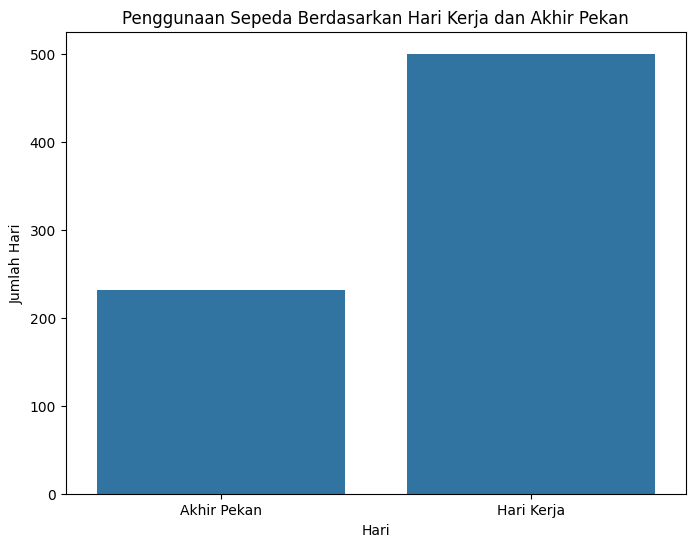

In [53]:
# Membuat bar chart
plt.figure(figsize=(8, 6))
sns.countplot(data=day_df, x='workingday')
plt.title('Penggunaan Sepeda Berdasarkan Hari Kerja dan Akhir Pekan')
plt.xlabel('Hari')
plt.ylabel('Jumlah Hari')
plt.show()

**Insight:**
- Distribusi penggunaan sepeda pada hari kerja lebih tinggi daripada akhir pekan
- Sepeda lebih sering digunakan sebagai alat transportasi untuk bekerja atau beraktivitas pada hari kerja

C:\Users\arbaz\AppData\Local\Temp\ipykernel_20524\270849862.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=hour_df, x='weathersit', y='cnt', estimator=np.mean, ci='sd')


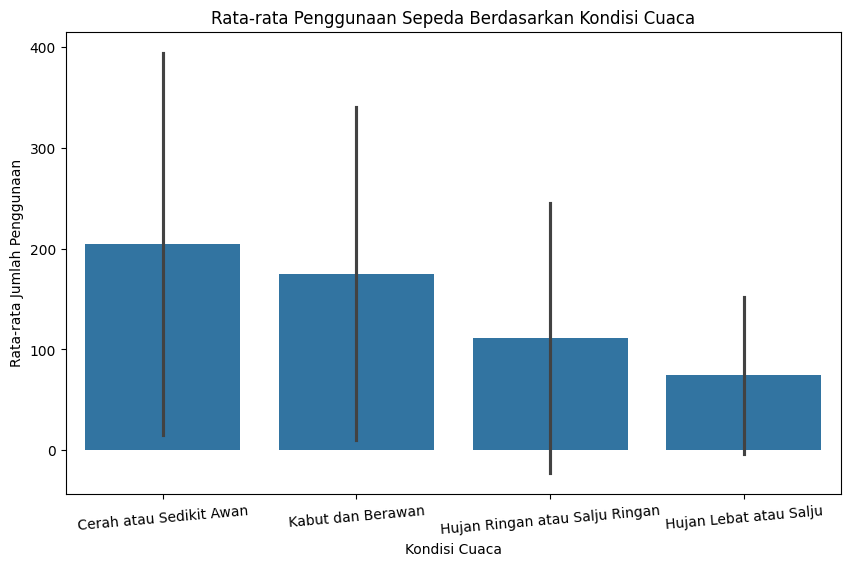

In [54]:
# Menggunakan replace untuk mengganti nilai season
# Menggunakan def untuk tidak menuliskan dua kali
def replace_weathersit(df):
    df["weathersit"] = df["weathersit"].replace({
        1: "Cerah atau Sedikit Awan",
        2: "Kabut dan Berawan",
        3: "Hujan Ringan atau Salju Ringan",
        4: "Hujan Lebat atau Salju"
    })
    return df

hour_df = replace_weathersit(hour_df)
day_df = replace_weathersit(day_df)

# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=hour_df, x='weathersit', y='cnt', estimator=np.mean, ci='sd')
plt.title('Rata-rata Penggunaan Sepeda Berdasarkan Kondisi Cuaca')
plt.xlabel('Kondisi Cuaca')
plt.ylabel('Rata-rata Jumlah Penggunaan')
plt.xticks(rotation=5)
plt.show()

**Insight:**
- Penggunaan sepeda lebih tinggi pada cuaca yang cerah dan menurun secara bertahap ketika cuaca menjadi lebih buruk, dengan penggunaan terendah terjadi pada saat hujan lebat.

### **Eksplorasi Data**

## Visualization & Explanatory Analysis

1. Bagaimana mengidentifikasi pola penggunaan sepeda berdasarkan waktu (jam) dalam sehari menggunakan clustering untuk mengoptimalkan ketersediaan sepeda?

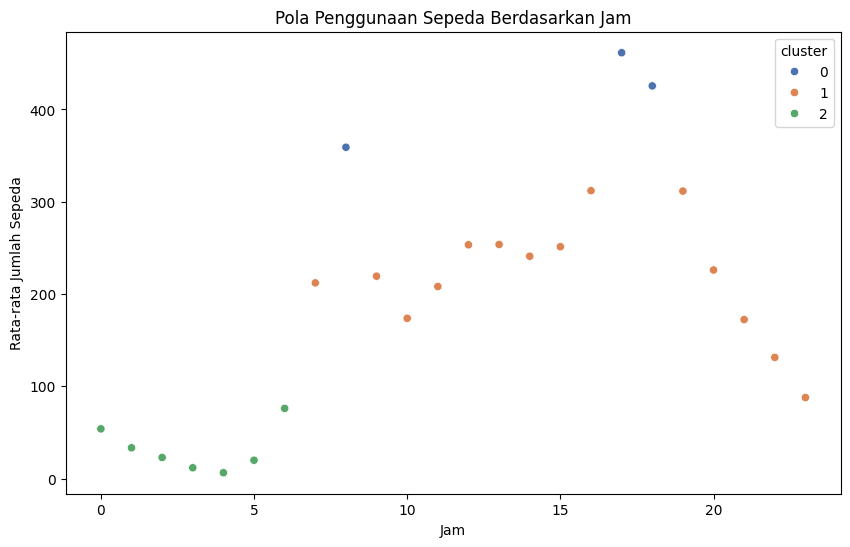


Karakteristik Cluster:

Cluster 0:
Jam: [8, 17, 18]
Rata-rata penggunaan: 415.32

Cluster 1:
Jam: [7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23]
Rata-rata penggunaan: 218.10

Cluster 2:
Jam: [0, 1, 2, 3, 4, 5, 6]
Rata-rata penggunaan: 32.02


In [55]:
# Menyimpan dataset "hour.csv" dalam variabel df
df = pd.read_csv('data/hour.csv')

# Mengelompokkan data berdasarkan kolom "hr" dan dihitung rata-rata jumlah pengguna sepeda untuk setiap jam
data_cluster = df.groupby('hr')[['cnt']].mean().reset_index()

# Normalisasi data dengan StandardScaler untuk mengubah skala variabel sehingga memiliki mean 0 dan sd 1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

# Melakukan clustering dengan KMeans (misalnya dengan 3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
data_cluster['cluster'] = kmeans.fit_predict(data_scaled)

# Visualisasi hasil dengan scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cluster, x='hr', y='cnt', hue='cluster', palette='deep')
plt.title('Pola Penggunaan Sepeda Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Rata-rata Jumlah Sepeda')
plt.show()

# Analisis karakteristik setiap cluster 
print("\nKarakteristik Cluster:")
for cluster in range(3):
    cluster_data = data_cluster[data_cluster['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Jam: {cluster_data['hr'].tolist()}")
    print(f"Rata-rata penggunaan: {cluster_data['cnt'].mean():.2f}")

2. Bagaimana pola penggunaan sepeda berbeda antara hari kerja dan akhir pekan menggunakan analisis RFM sederhana?

C:\Users\arbaz\AppData\Local\Temp\ipykernel_20524\2574763885.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m_work, m_weekend], labels=['Hari Kerja', 'Akhir Pekan'])


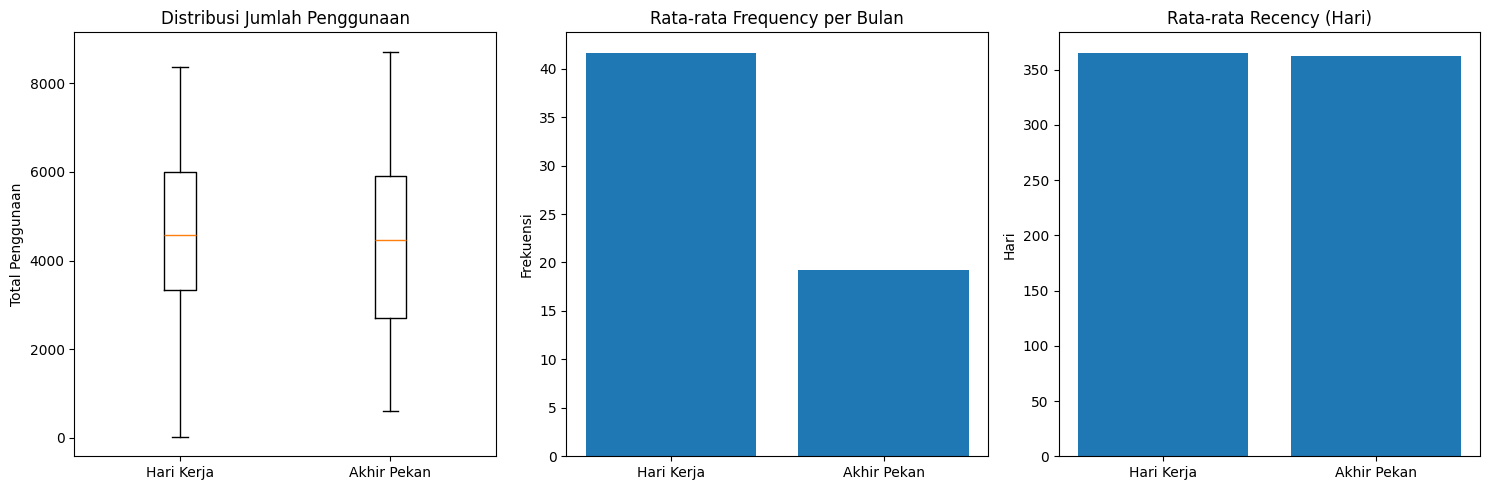


Ringkasan Statistik:

Hari Kerja:
Rata-rata penggunaan: 4584.82
Rata-rata frequency per bulan: 41.67
Rata-rata recency: 365.62 hari

Akhir Pekan:
Rata-rata penggunaan: 4330.17
Rata-rata frequency per bulan: 19.25
Rata-rata recency: 362.65 hari


In [56]:
# Menyimpan dataset "day.csv" dalam variabel df
df = pd.read_csv('data/day.csv')

# Menghitung metrik RFM sederhana
def calculate_rfm(data, is_workday):
    # Filter hari kerja atau akhir pekan berdasarkan kolom "workingday"
    subset = data[data['workingday'] == is_workday]
    
    # Recency: jumlah  hari sejak hari terakhir penggunaan sepeda hingga akhir data
    max_date = pd.to_datetime(subset['dteday']).max()
    recency = (max_date - pd.to_datetime(subset['dteday'])).dt.days
    
    # Frequency: jumlah hari penggunaan sepeda per bulan
    frequency = subset.groupby(pd.to_datetime(subset['dteday']).dt.month)['cnt'].count()
    
    # Monetary: jumlah penggunaan sepeda
    monetary = subset['cnt']
    
    return recency, frequency, monetary

# Menghitung RFM untuk hari kerja dan akhir pekan
r_work, f_work, m_work = calculate_rfm(df, 1)  # hari kerja
r_weekend, f_weekend, m_weekend = calculate_rfm(df, 0)  # akhir pekan

# Visualisasi perbandingan dengan ukuran 15x5 untuk visualisasi perbandingan
plt.figure(figsize=(15, 5))

# Monetary : membandingkan distribusi jumlah penggunaan sepeda hari kerja dengan akhir pekan dengan plot box plot
plt.subplot(1, 3, 1)
plt.boxplot([m_work, m_weekend], labels=['Hari Kerja', 'Akhir Pekan'])
plt.title('Distribusi Jumlah Penggunaan')
plt.ylabel('Total Penggunaan')

# Frequency : menampilkan rata-rata frekuensi penggunaan sepeda per bulan hari kerja dengan akhir pekan dengan bar plot
plt.subplot(1, 3, 2)
plt.bar(['Hari Kerja', 'Akhir Pekan'], 
        [f_work.mean(), f_weekend.mean()])
plt.title('Rata-rata Frequency per Bulan')
plt.ylabel('Frekuensi')

# Recency : menampilkan rata-rata recency (dalam hari) antara hari kerja dan akhir pekan dengan bar plot
plt.subplot(1, 3, 3)
plt.bar(['Hari Kerja', 'Akhir Pekan'], 
        [r_work.mean(), r_weekend.mean()])
plt.title('Rata-rata Recency (Hari)')
plt.ylabel('Hari')

plt.tight_layout()         # Supaya tampilan plot lebih rapi
plt.show()                 # Menampilkan plot

# Print ringkasan statistik untuk hari kerja dan akhir pekan
print("\nRingkasan Statistik:")
print("\nHari Kerja:")
print(f"Rata-rata penggunaan: {m_work.mean():.2f}")
print(f"Rata-rata frequency per bulan: {f_work.mean():.2f}")
print(f"Rata-rata recency: {r_work.mean():.2f} hari")

print("\nAkhir Pekan:")
print(f"Rata-rata penggunaan: {m_weekend.mean():.2f}")
print(f"Rata-rata frequency per bulan: {f_weekend.mean():.2f}")
print(f"Rata-rata recency: {r_weekend.mean():.2f} hari")

**Insight:**
- **Nomor 1**

Karakteristik Cluster:

_Cluster 0:_

Jam: [8, 17, 18]

Rata-rata penggunaan: 415.32

_Cluster 1:_

Jam: [7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23]

Rata-rata penggunaan: 218.10

_Cluster 2:_

Jam: [0, 1, 2, 3, 4, 5, 6]

Rata-rata penggunaan: 32.02

- **Nomor 2**

Ringkasan Statistik:

_Hari Kerja:_

Rata-rata penggunaan: 4584.82

Rata-rata frequency per bulan: 41.67

Rata-rata recency: 365.62 hari

_Akhir Pekan:_

Rata-rata penggunaan: 4330.17

Rata-rata frequency per bulan: 19.25

Rata-rata recency: 362.65 hari

## Conclusion

- Conclusion pertanyaan 1
  1. Terdapat tiga pola utalam dalam penggunaan sepeda berdasarkan jam dari hasil clustering dengan KMeans, yaitu:   
      - Cluster 0: menunjukkan jam-jam dengan jumlah penggunaan sepeda yang lebih rendah, saat pagi atau malam hari ketika aktivitas tidak tinggi.
      - Cluster 1: menunjukkan jam-jam dengan jumlah penggunaan sepeda yang lebih tinggi, saat jam kerja atau pulang kerja.
      - Cluster 2: menunjukkan jam-jam dengan jumlah penggunaan sepeda yang sangat tinggi, saat jam sibuk di pagi atau sore hari.
  2. Pola penggunaan sepeda berbeda setiap jam berdasarkan distribusi per jam dan penggunaan sepeda rata-rata di setiap klaster yang berguna untuk mengidentifikasi waktu dengan permintaan tinggi guna mengoptimalkan ketersediaan sepeda.

- Conclusion pertanyaan 2
  
  Sepeda lebih banyak dan lebih rutin digunakan pada hari kerja dibandingkan akhir pekan berdasarkan rata-rata penggunaan, frekuensi, dan recency. Hal ini menunjukkan pola penggunaan yang lebih dominan pada hari kerja, sedangkan pengunaan di akhir pekan cenderung lebih bervariasi tergantung pada kondisi cuaca, acara, atau aktivitas lainnya.

### Menyimpan berkas data yang telah dianalisis

In [57]:
# Menyimpan dataset "hour.csv" dalam variabel df
df = pd.read_csv('data/hour.csv')

# 1. Analisis Clustering berdasarkan waktu
def create_clustering_results():
    # Menghitung rata-rata penggunaan per jam
    hourly_pattern = df.groupby('hr')[['cnt']].mean().reset_index()
    
    # Clustering
    scaler = StandardScaler()                                          # Normalisasi kolom "cnt" pada "hourly_pattern"
    data_scaled = scaler.fit_transform(hourly_pattern)
    kmeans = KMeans(n_clusters=3, random_state=42)                     # Melakukan clustering dengan 3 cluster
    hourly_pattern['cluster'] = kmeans.fit_predict(data_scaled)
    
    return hourly_pattern                                              # Mengembalikan hasil clustering

# 2. Analisis RFM untuk hari kerja vs weekend
def create_rfm_results():
    # Membuat analisis RFM berdasarkan "workingday" dan "dteday"
    workday_analysis = df.groupby(['dteday', 'workingday']).agg({
        'cnt': 'sum',
        'casual': 'sum',
        'registered': 'sum'
    }).reset_index()
    
    return workday_analysis                                           # Mengembalikan hasil akumulasi RFM per tanggal dan kategori hari kerja

clustering_results = create_clustering_results()                      # Memanggil hasil analisis clustering dan disimpan dalam variavel clustering_results
rfm_results = create_rfm_results()                                    # Memanggil hasil analisis RFM dan disimpan dalam variabel rfm_results

# Menyimpan hasil analisis ke CSV
clustering_results.to_csv('clustering_results.csv',index=False)
rfm_results.to_csv('rfm_results.csv',index=False)